In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from IPython import display
display.set_matplotlib_formats('svg')

In [8]:
class BaldwinOptimize_Coding:
    
    def __init__(self,initial_points, spikeness, population_size=1000):
        self.current_points = initial_points
        self.good_gene = np.array([i%2 for i in range(20)])
        self.spikeness = spikeness
        self.score = []
        self.correct_ratio = []
        self.undecide_ratio = []
        self.incorrect_ratio = []
        self.good_cutoff = 0.5
        self.generation = 0
        self.population_size = population_size
        
        self.fitness_score = self.fitness(self.current_points)
        self.score.append(np.sum(self.fitness_score>=self.good_cutoff)/self.population_size) # Good Genotype fraction
        tmp_correct_ratio = np.sum(self.current_points == self.good_gene)/(20*self.population_size) # Corrrect Gene fraction
        tmp_undecide_ratio = np.sum(self.current_points == 2)/(20*self.population_size)  # Undecided Gene fraction
        self.correct_ratio.append(tmp_correct_ratio.copy()) 
        self.undecide_ratio.append(tmp_undecide_ratio.copy())
        self.incorrect_ratio.append(1-tmp_correct_ratio.copy()-tmp_undecide_ratio.copy())
        
        #TODO: Add Assertion about the dimension here
        
    def fitness(self, patterns=None):
        hamming_distance = np.sum(patterns != self.good_gene, axis=-1)
        return (1./self.spikeness)**hamming_distance
        
    #TODO: Make this parallel    
    def learning(self,n_steps=1000):
        cut_off = self.good_cutoff
        fitness_function = self.fitness
        
        #TODO: make this function parallel
        def random_trail(start_point):
            w = np.argwhere(start_point==2).reshape(-1)
            if len(w) == 0:
                if fitness_function(start_point)>=cut_off:
                    return 1.
                else:
                    return 0
            for i in range(n_steps):
                tmp_pattern = start_point.copy()
                tmp_pattern[w] = np.random.randint(2,size=len(w))
                if fitness_function(tmp_pattern) >= cut_off:
                    break
            return (n_steps-i-1.)/n_steps
        
        self.learning_score = np.array([random_trail(point) for point in self.current_points])
    
    def competition(self, alpha=1, beta=19):
        if beta > 0:
            self.reproducibility = alpha*self.fitness_score + beta*self.learning_score + 1e-6
            self.reproducibility = self.reproducibility/np.sum(self.reproducibility)
        else:
            self.reproducibility = self.fitness_score + 1e-6
            self.reproducibility = self.reproducibility/np.sum(self.reproducibility)
    
    def selectivity(self):
        self.parent_index = np.random.choice(self.population_size,size=[self.population_size,2], p=self.reproducibility)
    
    def recombination(self):
        offsprings = []
        for i in range(self.population_size):
            mid = np.random.randint(1,19)
            tmp_offspring = np.concatenate((self.current_points[self.parent_index[i,0],0:mid],self.current_points[self.parent_index[i,1],mid:]))
            offsprings.append(tmp_offspring)
        self.current_points = np.array(offsprings)
    
    def mutation(self, rate=1e-4):
        
        def flip(x):
            new = []
            for i in x:
                if i==0:
                    new.append(np.random.choice([1,2]))
                elif i==1:
                    new.append(np.random.choice([0,2]))
                elif i==2:
                    new.append(np.random.choice([0,1]))
            return np.array(new)
        
        if rate > 0:
            mutate_index = np.where(np.sign(np.random.rand(*self.current_points.shape) - rate) == -1)
            if len(mutate_index[0]) > 0:
                self.current_points[mutate_index] = flip(self.current_points[mutate_index])    
               
    def evolve(self, alpha=1, beta=19, mutation_rate = 1e-4, learning_nsteps=1000):
        '''
        Evolve for one generation
        alpha: scale for fitness effect
        beta: scale for learning effect
        '''
        self.fitness_score = self.fitness(self.current_points)
        if beta > 0:
            self.learning(n_steps=learning_nsteps)
            self.competition(alpha=alpha, beta=beta)
        else:
            self.competition(alpha=1,beta=0)
        self.selectivity()
        self.recombination()
        self.mutation(rate=mutation_rate)
        self.generation += 1
        self.evaluate()
    
    def evaluate(self):
        self.fitness_score = self.fitness(self.current_points)
        self.score.append(np.sum(self.fitness_score>=self.good_cutoff)/self.population_size) # Good Genotype fraction
        tmp_correct_ratio = np.sum(self.current_points == self.good_gene)/(20*self.population_size) # Corrrect Gene fraction
        tmp_undecide_ratio = np.sum(self.current_points == 2)/(20*self.population_size)  # Undecided Gene fraction
        self.correct_ratio.append(tmp_correct_ratio.copy()) 
        self.undecide_ratio.append(tmp_undecide_ratio.copy())
        self.incorrect_ratio.append(1-tmp_correct_ratio.copy()-tmp_undecide_ratio.copy())

In [5]:
def plot_ratios(BOC1, BOC2, output=None):
    fig,ax=plt.subplots(2,1,sharex=True, figsize=[5,6])
    ax[0].plot(BOC1.correct_ratio,'.-', label='Correct Gene Ratio')
    ax[0].plot(BOC1.incorrect_ratio,'.-', label='Incorrect Gene Ratio')
    ax[0].plot(BOC1.undecide_ratio,'.-', label='Undecided Gene Ratio')
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_ylim(-0.08,1.08)
    ax[0].legend()
    ax[0].set_title("With Learning Step, Spikeness={}".format(BOC1.spikeness))
    ax[1].plot(BOC2.correct_ratio,'.-', label='Correct Gene Ratio')
    ax[1].plot(BOC2.incorrect_ratio,'.-', label='Incorrect Gene Ratio')
    ax[1].plot(BOC2.undecide_ratio,'.-', label='Undecided Gene Ratio')
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_ylim(-0.08,1.08)
    ax[1].set_xlabel("Generations")
    ax[1].set_title("Without Learning Step, Spikeness={}".format(BOC1.spikeness))
    if output:
        plt.savefig(output,dpi=200,transparent=True,bbox_inches='tight')
    plt.show()

In [6]:
initial_points = np.random.choice(3,size=[1000,20],p=[0.25,0.25,0.50])
BOC1 = BaldwinOptimize_Coding(initial_points,10)
BOC1_nolearing = BaldwinOptimize_Coding(initial_points,10)
for i in tqdm(range(50)):
    BOC1.evolve(alpha=1,beta=19, mutation_rate = 1e-4)
    BOC1_nolearing.evolve(alpha=1,beta=0, mutation_rate = 1e-4)

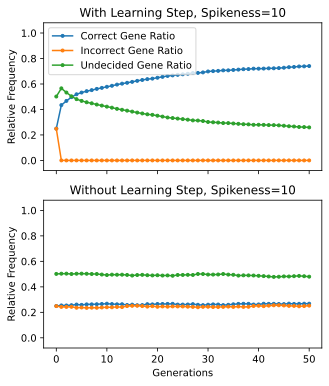

In [22]:
plot_ratios(BOC1, BOC1_nolearing, output="1e-4Mutation.png")

In [9]:
initial_points = np.random.choice(3,size=[1000,20],p=[0.25,0.25,0.50])
BOC2 = BaldwinOptimize_Coding(initial_points,10)
BOC2_nolearing = BaldwinOptimize_Coding(initial_points,10)
for i in tqdm(range(50)):
    BOC2.evolve(alpha=1,beta=19, mutation_rate = 1e-3)
    BOC2_nolearing.evolve(alpha=1,beta=0, mutation_rate = 1e-3)

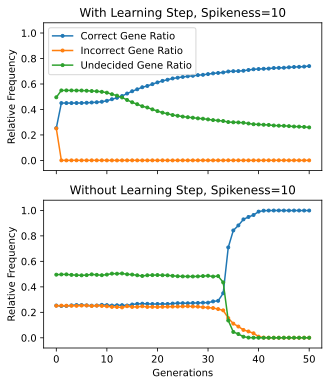

In [21]:
plot_ratios(BOC2, BOC2_nolearing, output="1e-3Mutation.png")

In [11]:
initial_points = np.random.choice(3,size=[1000,20],p=[0.25,0.25,0.50])
BOC3 = BaldwinOptimize_Coding(initial_points,10)
BOC3_nolearing = BaldwinOptimize_Coding(initial_points,10)
for i in tqdm(range(50)):
    BOC3.evolve(alpha=1,beta=19, mutation_rate = 1e-2)
    BOC3_nolearing.evolve(alpha=1,beta=0, mutation_rate = 1e-2)

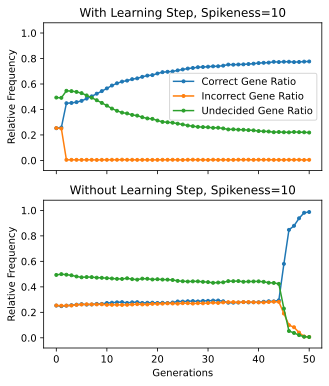

In [20]:
plot_ratios(BOC3, BOC3_nolearing,output="1e-2Mutation.png")

In [14]:
initial_points = np.random.choice(3,size=[1000,20],p=[0.25,0.25,0.50])
BOC4 = BaldwinOptimize_Coding(initial_points,10)
BOC4_nolearing = BaldwinOptimize_Coding(initial_points,10)
for i in tqdm(range(50)):
    BOC4.evolve(alpha=1,beta=19, mutation_rate = 1e-1)
    BOC4_nolearing.evolve(alpha=1,beta=0, mutation_rate = 1e-1)

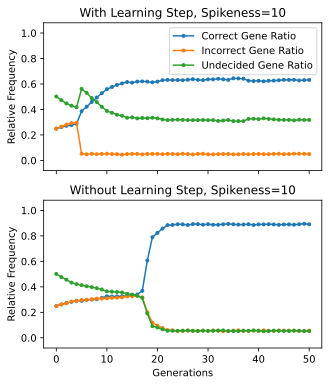

In [19]:
plot_ratios(BOC4, BOC4_nolearing, output="1e-1Mutation.png")